In [1]:
#Runs successfully on MBP 2024 metal_102 conda environment.
import numpy as np
import torch
import torch.nn as nn
import pymc as pm
from pymc.util import get_value_vars_from_user_vars
import arviz as az
import pytensor.tensor as tt
from pytensor import scan
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
# Suppress PyTorch warnings
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Use CPU instead of GPU
print(pm.__version__)

5.12.0


In [2]:
import cProfile
import pstats

def profile_func(func):
    def wrapper(*args, **kwargs):
        profiler = cProfile.Profile()
        result = profiler.runcall(func, *args, **kwargs)
        stats = pstats.Stats(profiler).sort_stats('cumulative')
        stats.print_stats(20)  # Print top 20 time-consuming operations
        return result
    return wrapper




In [3]:
# Define constants
SIZE = 200
T=200
dt=0.1
NUM_SAMPLES = 100
EPOCHS = 1000
DEBUG = True

In [27]:
import pymc as pm
from pymc.step_methods import CompoundStep, Metropolis
import numpy as np
import pytensor.tensor as pt
import torch

class CustomGANStep(CompoundStep):
    def __init__(self, vars, discriminator, T=200, dt=0.1, debug=False):
        # Create a Metropolis step for each variable
        metropolis_steps = [Metropolis([var]) for var in vars]
        
        # Initialize CompoundStep with these Metropolis steps
        super().__init__(metropolis_steps)

        # Store additional information in a dictionary
        self.gan_info = {
            'discriminator': discriminator,
            'T': T,
            'dt': dt,
            'vars': vars,
            'var_names': [var.name for var in vars]
        }
        self.debug = debug
        if self.debug:
            print(f"Initialized CustomGANStep with variables: {self.gan_info['var_names']}")

    def step(self, point):
        q = []
        for var in self.gan_info['vars']:
            if var.name in point:
                value = point[var.name]
            else:
                # Try to find a matching key (e.g., 'kc21_logodds__' for 'kc21')
                matching_key = next((k for k in point.keys() if k.startswith(var.name)), None)
                if matching_key:
                    value = point[matching_key]
                else:
                    raise KeyError(f"Cannot find a matching key for variable {var.name}")
            
            # Check if the variable has a distribution (i.e., is a random variable)
            if hasattr(var, 'distribution') and hasattr(var.distribution, 'transform_used'):
                transform = var.distribution.transform_used
                q.append(transform.backward(value).eval())
            else:
                # If it's not a random variable, just use the value as is
                q.append(value)
        
        if self.debug:
            print(f"Current params: {q}")

        q_new = self.proposal(q)
        if self.debug:
            print(f"Proposed params: {q_new}")


        # Generate synthetic data
        synthetic_data_current = self.generate_synthetic_data(q)
        synthetic_data_proposed = self.generate_synthetic_data(q_new)

        # Get discriminator scores
        current_disc_score = self.get_discriminator_score(synthetic_data_current)
        proposed_disc_score = self.get_discriminator_score(synthetic_data_proposed)

        # Compute acceptance probability
        accept = self.compute_acceptance(point, q_new, current_disc_score, proposed_disc_score)

        # Ensure accept is a scalar float
        accept_prob = float(accept)

        if np.random.random() < accept_prob:
            for var, val in zip(self.gan_info['vars'], q_new):
                if var.name in point:
                    point[var.name] = np.atleast_1d(val)
                else:
                    matching_key = next(k for k in point.keys() if k.startswith(var.name))
                    point[matching_key] = np.atleast_1d(val)
        else:
            for var in self.gan_info['vars']:
                if var.name in point:
                    point[var.name] = np.atleast_1d(point[var.name])
                else:
                    matching_key = next(k for k in point.keys() if k.startswith(var.name))
                    point[matching_key] = np.atleast_1d(point[matching_key])

        # Return the new point and an empty stats dictionary
        return point, {}

    def proposal(self, q):
        return [val + np.random.normal(0, 0.1 * (np.abs(val) + 1e-8)) for val in q]

    def compute_acceptance(self, current_point, proposed_values, current_disc_score, proposed_disc_score):
        current_logp = self.logp(current_point)
        
        proposed_point = current_point.copy()
        for var, val in zip(self.gan_info['vars'], proposed_values):
            if var.name in proposed_point:
                proposed_point[var.name] = val
            else:
                matching_key = next(k for k in proposed_point.keys() if k.startswith(var.name))
                proposed_point[matching_key] = val
        
        proposed_logp = self.logp(proposed_point)

        # Metropolis-Hastings acceptance ratio
        ratio = pt.exp(proposed_logp - current_logp)

        # Incorporate discriminator scores
        ratio = ratio * np.exp(proposed_disc_score - current_disc_score)

        # Ensure ratio is a scalar
        ratio = pt.as_tensor_variable(ratio).eval()

        return min(1, ratio)

    def generate_synthetic_data(self, params):
        if self.debug:
            print(f"Params passed to generate_synthetic_data: {params}")
        params = [float(p) for p in params]  # Convert to float
        return pymc_sim_channel(params, self.gan_info['T'], self.gan_info['dt'], source="torch")

    def get_discriminator_score(self, data):
        if isinstance(data, torch.Tensor):
            data_tensor = data.clone().detach().float().unsqueeze(0)
        else:
            data_tensor = torch.tensor(data).float().unsqueeze(0)
        with torch.no_grad():
            score = self.gan_info['discriminator'](data_tensor).item()
        return score

    def logp(self, point):
        logp_sum = 0
        for var in self.gan_info['vars']:
            if var.name in point:
                value = point[var.name]
            else:
                matching_key = next((k for k in point.keys() if k.startswith(var.name)), None)
                if matching_key:
                    value = point[matching_key]
                else:
                    raise KeyError(f"Cannot find a matching key for variable {var.name}")
            
            if hasattr(var, 'distribution'):
                if hasattr(var.distribution, 'transform_used'):
                    transform = var.distribution.transform_used
                    transformed_value = transform.backward(value).eval()
                else:
                    transformed_value = value
                logp_sum += var.distribution.logp(transformed_value).sum()
            # If it's not a random variable, we don't add to the logp
        return logp_sum

In [28]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * (SIZE // 4), 1)
        )

    def forward(self, x):
        return self.model(x.permute(0, 2, 1))

In [29]:
# Loss function for the discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output))
    fake_loss = nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

In [30]:
# Create and compile the discriminator
discriminator = Discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [31]:
import pytensor.tensor as tt
from pytensor.scan import scan
from pytensor.tensor.random.utils import RandomStream
import torch
import numpy as np

def pymc_sim_channel(params, T, dt, source="torch"):
    kc12, kc21, Fnoise, scale, offset, kco1, koc2, ko12, ko21 = params
    eps = 1e-10  # Small constant to avoid zero probabilities
    if source == "pymc":
        zero = tt.constant(0.0)
        one = tt.constant(1.0)
        
        # Convert parameters to PyTensor tensors
        """
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(tt.as_tensor_variable, 
                                                                        [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])

        """
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(lambda x: tt.maximum(tt.as_tensor_variable(x), eps), 
                                                                [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])
        # Create transition matrix
        row1 = tt.stack([1-kc12, kc12, zero, zero])
        row2 = tt.stack([kc21, 1-kc21-kco1, kco1, zero])
        row3 = tt.stack([zero, koc2, 1-koc2-ko12, ko12])
        row4 = tt.stack([zero, zero, ko21, 1-ko21])
        transition_matrix = tt.stack([row1, row2, row3, row4])

        transition_matrix = tt.maximum(transition_matrix, eps)
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_matrix = transition_matrix / row_sums
        
        # Create a RandomStream for managing the RNG
        srng = RandomStream()
        
        # Generate random initial state
        initial_state = srng.categorical(tt.ones(4) / 4, size=(1,))
        
        def step(state, transition_probs):
            new_state = srng.categorical(transition_probs[state[0]], size=(1,))
            return new_state
        
        states, _ = scan(
            fn=step,
            outputs_info=initial_state,
            non_sequences=transition_matrix,
            n_steps=SIZE-1
        )
        
        states = tt.concatenate([initial_state, states.flatten()])
        
        # Convert states to channels
        channels = tt.switch(states < 2, zero, one)
        
        # Generate noise
        noise = srng.normal(0, Fnoise, size=(SIZE,))
        
        # Combine channels and noise
        result = tt.stack([channels, channels * scale + offset + noise], axis=-1)
        
        # Return the PyTensor variable directly
        return result


    else:
        # Convert to PyTorch tensors
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(lambda x: torch.tensor(max(x, eps)), 
                                                                        [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])
        
        # Create transition matrix
        row1 = torch.tensor([1-kc12, kc12, 0, 0])
        row2 = torch.tensor([kc21, 1-kc21-kco1, kco1, 0])
        row3 = torch.tensor([0, koc2, 1-koc2-ko12, ko12])
        row4 = torch.tensor([0, 0, ko21, 1-ko21])
                
        transition_matrix = torch.stack([row1, row2, row3, row4])
        
        # Ensure non-negative values and add small constant
        transition_matrix = torch.clamp(transition_matrix, min=eps)
        
        # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(dim=1, keepdim=True)
        transition_matrix = transition_matrix / row_sums
        
        def transition_fn(state):
            probs = transition_matrix[state]
            return torch.distributions.Categorical(probs=probs).sample()
        
        initial_probs = torch.ones(4) / 4  # Equal probability for all initial states
        initial_distribution = torch.distributions.Categorical(probs=initial_probs)
        
        states = [initial_distribution.sample().item()]
        
        for _ in range(SIZE - 1):
            states.append(transition_fn(states[-1]).item())
        
        channels = torch.tensor(states)
        channels = torch.where(channels < 2, torch.zeros_like(channels), torch.ones_like(channels))
        noise = torch.normal(0, Fnoise, (SIZE,))
        
        res = torch.stack([channels, channels * scale + offset + noise], axis=-1)
        return res

Text(0.5, 1.0, 'torch sim Channel Data')

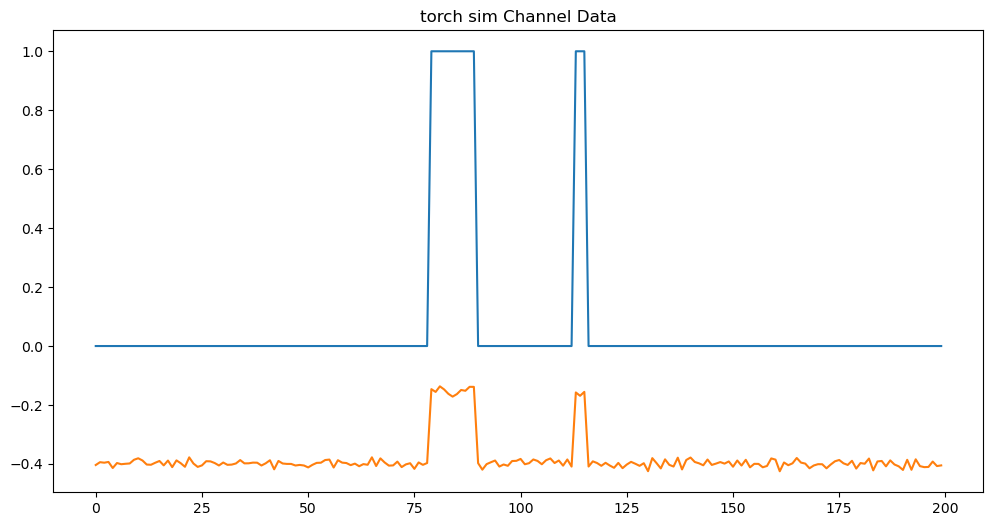

In [32]:
kc12=0.1
kc21=2
Fnoise=0.01
scale=0.25
offset=-0.4
kco1=0.5
kco2=0.25
ko12=1
ko21=2 
orig_params=[kc12,kc21,Fnoise,scale, offset,kco1,kco2,ko12,ko21]
plt.figure(figsize=(12, 6))
plt.plot(pymc_sim_channel(orig_params, T, dt))
plt.title('torch sim Channel Data')

In [33]:
real_data = torch.stack([pymc_sim_channel(orig_params, T, dt) for _ in range(NUM_SAMPLES)], dim=0)

/var/folders/_n/b_grcm9j7pd5hrdkdnkl728m0000gn/T/ipykernel_97307/2441911285.py:43: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_predictive = pm.sample_prior_predictive(samples=1000)
Sampling: [Fnoise, kc12, kc21, kco1, ko12, ko21, koc2, offset, scale]


Model structure:
kc21: TensorVariable
  Potential
kc12: TensorVariable
  Potential
kco1: TensorVariable
  Potential
koc2: TensorVariable
  Potential
ko12: TensorVariable
  Potential
ko21: TensorVariable
  Potential
Fnoise: TensorVariable
  Potential
scale: TensorVariable
  Potential
offset: TensorVariable
  Potential
discriminator_probs: TensorSharedVariable
  Potential
likelihood: TensorVariable
  Potential

Random draw from prior:
koc2: mean = 0.2928, std = 0.1635
kco1: mean = 0.2896, std = 0.1638
kc12: mean = 0.2855, std = 0.1586
kc21: mean = 0.2803, std = 0.1618
ko12: mean = 0.2902, std = 0.1603
ko21: mean = 0.2811, std = 0.1564
offset: mean = -0.0178, std = 0.9816
Fnoise: mean = 0.7961, std = 0.6165
scale: mean = 0.7747, std = 0.5935

Prior distributions:


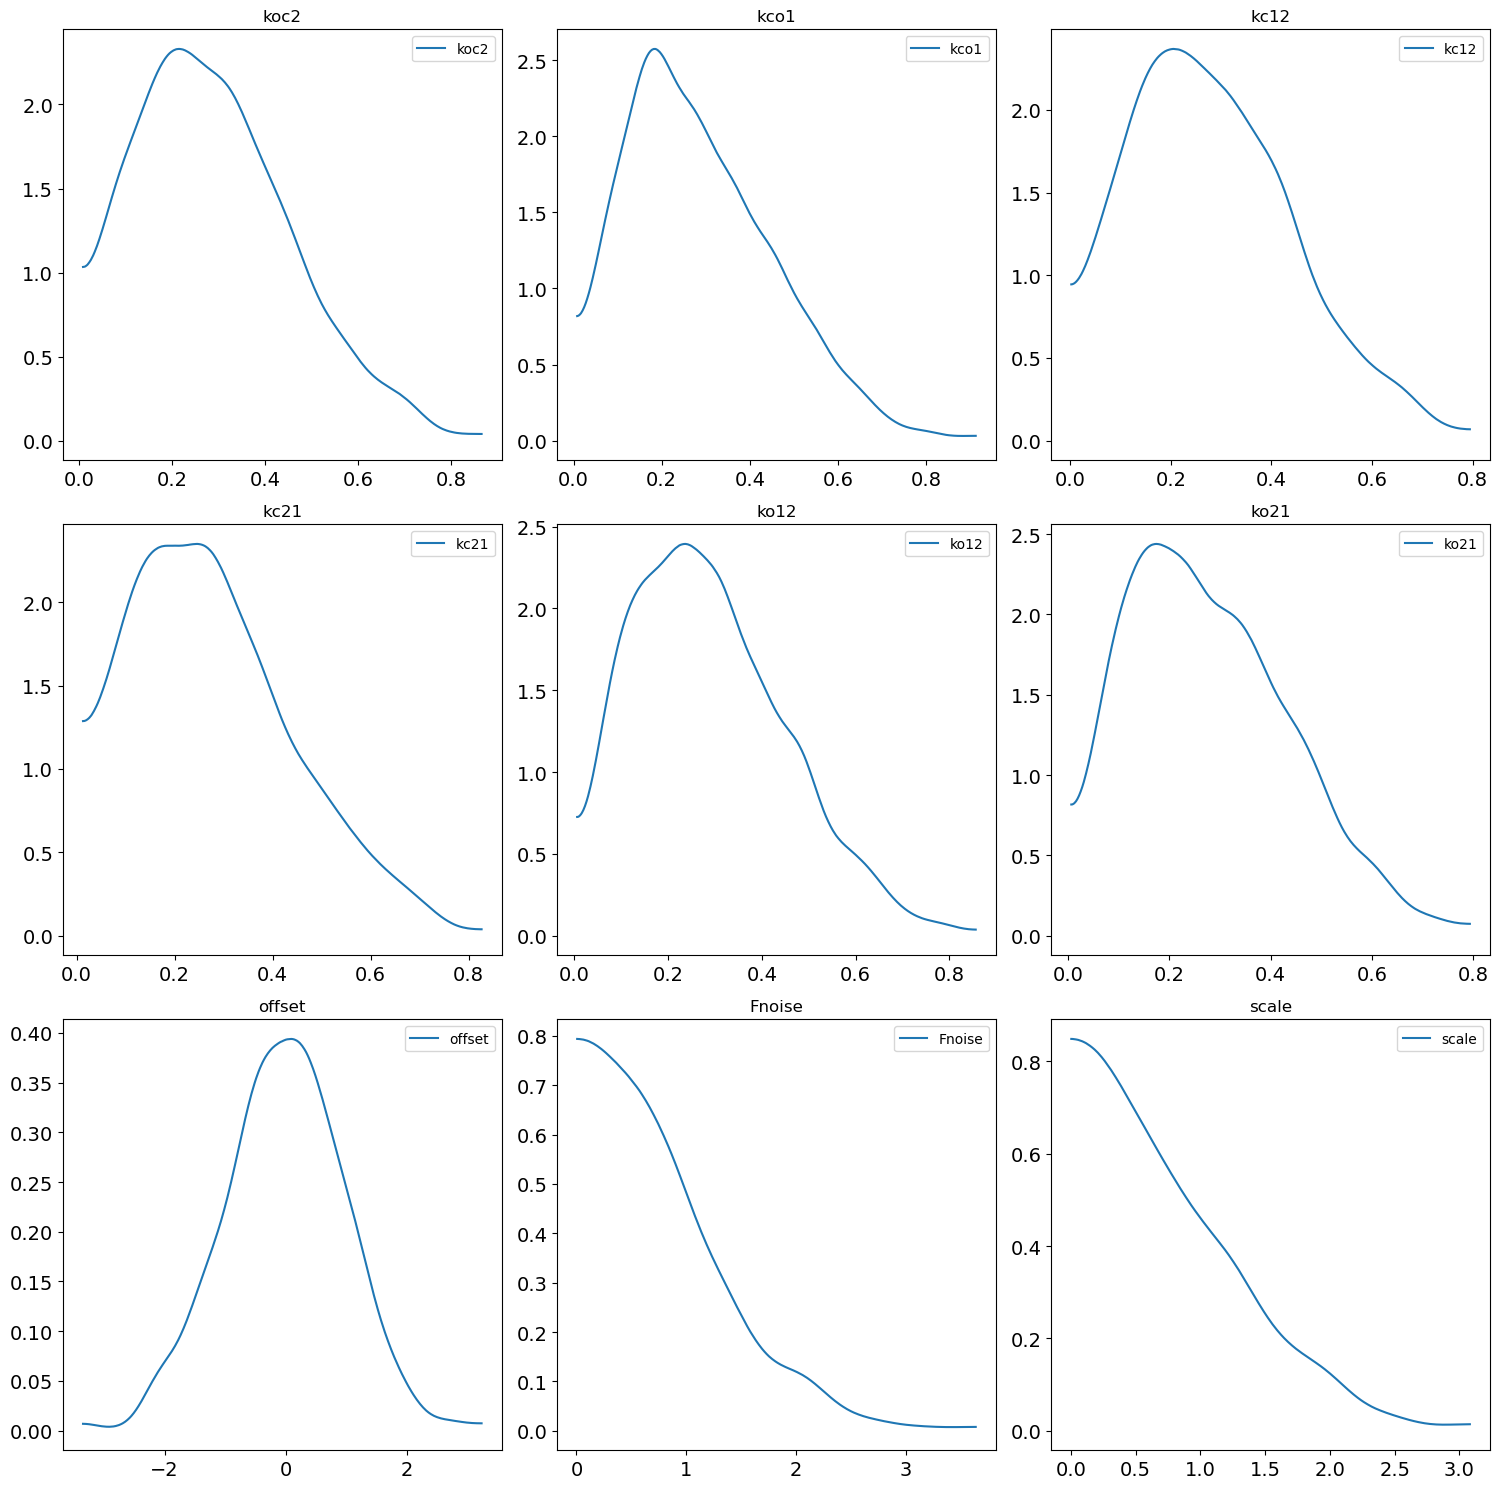


Model created successfully!


In [34]:
import pymc as pm
import pytensor.tensor as tt
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def create_model(T, dt, NUM_SAMPLES):
    with pm.Model() as model:
        # Priors for parameters (using transformed distributions to ensure valid ranges)
        kc21 = pm.Beta('kc21', alpha=2, beta=5)
        kc12 = pm.Beta('kc12', alpha=2, beta=5)
        kco1 = pm.Beta('kco1', alpha=2, beta=5)
        koc2 = pm.Beta('koc2', alpha=2, beta=5)
        ko12 = pm.Beta('ko12', alpha=2, beta=5)
        ko21 = pm.Beta('ko21', alpha=2, beta=5)
        Fnoise = pm.HalfNormal('Fnoise', sigma=1)
        scale = pm.HalfNormal('scale', sigma=1)
        offset = pm.Normal('offset', mu=0, sigma=1)

        # Placeholder for discriminator probabilities
        discriminator_probs = pm.MutableData('discriminator_probs', np.ones(NUM_SAMPLES) * 0.5)

        # Add a small epsilon to avoid log(0) or log(1)
        epsilon = 1e-7
        safe_probs = tt.clip(discriminator_probs, epsilon, 1 - epsilon)

        # Likelihood based on discriminator probabilities
        likelihood = pm.Potential('likelihood', tt.sum(tt.log(safe_probs)))

        # Debugging information
        if DEBUG:
            print("Model structure:")
            for v in model.named_vars.values():
                print(f"{v.name}: {type(v).__name__}")
                if hasattr(v, 'distribution'):
                    print(f"  Distribution: {type(v.distribution).__name__}")
                elif hasattr(v, 'tag'):
                    print(f"  Potential")
                else:
                    print(f"  Type: {type(v)}")

        print("\nRandom draw from prior:")
        prior_predictive = pm.sample_prior_predictive(samples=1000)
        for var_name, value in prior_predictive.prior.items():
            if var_name != 'discriminator_probs':
                print(f"{var_name}: mean = {value.mean().item():.4f}, std = {value.std().item():.4f}")

        print("\nPrior distributions:")
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        axes = axes.flatten()
        for i, (var_name, value) in enumerate(prior_predictive.prior.items()):
            if var_name != 'discriminator_probs':
                az.plot_dist(value, ax=axes[i], label=var_name)
                axes[i].set_title(var_name)
                axes[i].legend()
        plt.tight_layout()
        plt.show()

    return model

# Usage
model = create_model(T, dt, NUM_SAMPLES)
print("\nModel created successfully!")

In [35]:
def generate_synthetic_data(inference_data, num_samples, T, dt):
    # Extract parameters from the InferenceData object
    params = {var: inference_data.prior[var].values.flatten() for var in inference_data.prior.data_vars}
    
    synthetic_data = []
    for i in range(num_samples):
        # Randomly select a set of parameters
        sample_params = [np.random.choice(params[var]) for var in ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']]
        # Generate a single synthetic data sample
        sample = pymc_sim_channel(sample_params, T, dt, source="torch")
        
        synthetic_data.append(sample)
    
    # Stack all samples into a single tensor
    return torch.stack(synthetic_data).float()

In [36]:
def custom_prior_predictive(model, num_samples, discriminator, T, dt):
    with model:
        # Sample from priors
        prior_samples = pm.sample_prior_predictive(samples=num_samples)
    
    # Extract parameter values from prior_samples
    param_values = {}
    for var in model.free_RVs:
        if var.name in prior_samples.prior:
            values = prior_samples.prior[var.name].values
            if values.ndim > 1:
                param_values[var.name] = values.reshape(num_samples, -1)
            else:
                param_values[var.name] = values.reshape(-1, 1)
        else:
            print(f"Warning: {var.name} not found in prior samples. Using random values.")
            param_values[var.name] = np.random.uniform(0, 1, (num_samples, 1))
    
    # Generate synthetic data
    synthetic_data = []
    for i in range(num_samples):
        sample_params = [param_values[var.name][i].flatten()[0] for var in model.free_RVs]
        sample = pymc_sim_channel(sample_params, T, dt, source="torch")
        synthetic_data.append(sample)
    
    synthetic_data = torch.stack(synthetic_data).float()
    
    # Get discriminator probabilities
    with torch.no_grad():
        disc_probs = torch.sigmoid(discriminator(synthetic_data)).numpy()
    
    # Adjust samples based on discriminator probabilities
    adjusted_samples = {}
    for var in model.free_RVs:
        adjusted_samples[var.name] = param_values[var.name] * disc_probs.reshape(-1, 1)
    
    return adjusted_samples

# Usage
prior_predictive = custom_prior_predictive(model, NUM_SAMPLES, discriminator, T, dt)

/var/folders/_n/b_grcm9j7pd5hrdkdnkl728m0000gn/T/ipykernel_97307/3717247554.py:4: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_samples = pm.sample_prior_predictive(samples=num_samples)
Sampling: [Fnoise, kc12, kc21, kco1, ko12, ko21, koc2, offset, scale]


In [37]:
class StepSkipException(Exception):
    pass


traces = []

def print_error(section, e):
    print(f"Error in {section}: {str(e)}")
    print(f"Traceback for {section}:")
    import traceback
    print(traceback.format_exc())

@profile_func
def train(epoch):
    try:
        # Generate synthetic data using current model state
        prior_predictive = pm.sample_prior_predictive(samples=NUM_SAMPLES)
        synthetic_data = generate_synthetic_data(prior_predictive, NUM_SAMPLES, T, dt)
    except Exception as e:
        print_error("synthetic data generation", e)
        raise StepSkipException(f"Error in {step} step: {str(e)}")
    
    try:
        # Train discriminator
        real_output = discriminator(real_data)
        fake_output = discriminator(synthetic_data)
        disc_loss = discriminator_loss(real_output, fake_output)
        discriminator_optimizer.zero_grad()
        disc_loss.backward()
        
        discriminator_optimizer.step()
        print(f"Discriminator Loss: {disc_loss.item()}")
    except Exception as e:
        print_error("discriminator training", e)
        raise StepSkipException(f"Error in {step} step: {str(e)}")

    if epoch < 0:
        trace = pm.sample(5000, chains=4, 
                          tune=100, cores=16, return_inferencedata=True)
        traces.append(trace)
    else:  
        start = pm.find_MAP()
        try:
            # Perform MCMC with custom step method
            custom_step = CustomGANStep(vars=model.free_RVs, discriminator=discriminator, T=T, dt=dt, debug=DEBUG)
            print("Starting MCMC sampling with CustomGANStep")
            trace = pm.sample(50, step=custom_step, chains=2, 
                  tune=25, cores=2, return_inferencedata=True, start=start)
            traces.append(trace)
        except Exception as e:
            print_error("MCMC sampling", e)
            raise StepSkipException(f"Error in {step} step: {str(e)}")
        
    try:
        # Print progress
        if len(traces) > 1:
            combined_trace = az.concat(traces, dim="chain")
        else:
            combined_trace = traces[0]
        clear_output(wait=True)
        summary = az.summary(combined_trace)
        print(summary)
    except Exception as e:
        print_error("summary generation", e)
        raise StepSkipException(f"Error in {step} step: {str(e)}")
    


with model:
    print(f"Model variables: {[var.name for var in model.free_RVs]}")
    
    for epoch in tqdm(range(EPOCHS)):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        train(epoch)
        
        # Uncomment the following line if you want to clear output in a Jupyter notebook
        # clear_output(wait=True)

# After training, analyze the results
try:
    if len(traces) > 1:
        final_trace = az.concat(traces, dim="chain")
    else:
        final_trace = traces[0]
    az.plot_trace(final_trace)
    plt.show()
except Exception as e:
    print_error("plotting traces", e)

arviz - WARNING - Array contains NaN-value.


        mean  sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
offset   NaN NaN     0.0      NaN        NaN      NaN       NaN       NaN   
kc21     NaN NaN     0.2      NaN        NaN      NaN       NaN       NaN   
kc12     NaN NaN     0.2      NaN        NaN      NaN       NaN       NaN   
kco1     NaN NaN     0.2      NaN        NaN      NaN       NaN       NaN   
koc2     NaN NaN     0.2      NaN        NaN      NaN       NaN       NaN   
ko12     NaN NaN     0.2      NaN        NaN      NaN       NaN       NaN   
ko21     NaN NaN     0.2      NaN        NaN      NaN       NaN       NaN   
Fnoise   NaN NaN     0.0      NaN        NaN      NaN       NaN       NaN   
scale    NaN NaN     0.0      NaN        NaN      NaN       NaN       NaN   

        r_hat  
offset    NaN  
kc21      NaN  
kc12      NaN  
kco1      NaN  
koc2      NaN  
ko12      NaN  
ko21      NaN  
Fnoise    NaN  
scale     NaN  


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105d97340>>
Traceback (most recent call last):
  File "/Users/rbj/miniconda3/envs/metal_102/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  1%|█▍                                                                                                             | 13/1000 [03:54<4:56:56, 18.05s/it]


KeyboardInterrupt: 

In [ ]:
az.plot_trace(trace)
